# Seawater intrusion

In coastal aquifers, fresh groundwater (derived from terrestrial recharge) interacts with seawater. The location where the fresh groundwater and the seawater interact is commonly referred to as the interface. As seawater is denser than freshwater, the seawater tends to form a wedge under the freshwater. A conceptual model of an unconfined coastal aquifer is shown in Figure 1. 

<img src="SWI_fig_1.png" width="500"/>

**Figure 1. Description of hydrogeological variables for an unconfined coastal aquifer (from Morgan et al. 2013).**

The water budget involves net recharge to the aquifer $ W_{net} $ [L<sup>2</sup>/T]  (which accounts for infiltration, evapotranspiration and distributed pumping), flow into the aquifer through the inland boundary $ q_{b} $ [L<sup>2</sup>/T] and the flow at the coast $ q_{0} $ [L<sup>2</sup>/T]. 

The hydraulic head $ h_f $ [L] is related to the depth of the interface $ z $ [L] by the Ghyben-Herzberg relation $ z = h_f / δ $. Where $ δ $ [-] is the dimensionless density ratio, and $ ρ_s $ (= 1025 kg/m<sup>3</sup>) and $ ρ_f $ (= 1000 kg/m<sup>3</sup>) are freshwater and seawater densities, respectively [M/L<sup>3</sup>], so that $ δ $ = 0.025. 

 The freshwater thickness is $ h $ [L], and the base of the aquifer is $ z_0 $ [L] below mean sea level. Zone 1 is the region inland of the saltwater wedge and Zone 2 is the region between the coast and the inland extent ($ x_T $) of the saltwater wedge. $ x_T $ is commonly referred to as the wedge toe.

In [3]:
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, FloatSlider
%matplotlib inline

Observation data is in zone 1
q0 = 0.2658247775496236
xt = 196.78455182822927
19.999999999999993 20.0


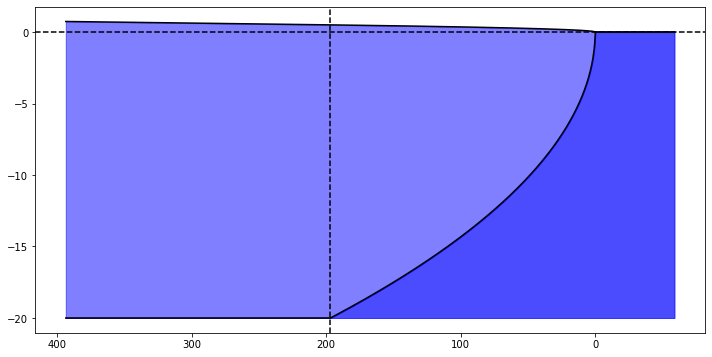

In [4]:
# all units in m and d
K = 10.
Wnet = 20.*1.e-3/365.25  # convert to m/d
z0 = 20.
hb = 3.
xb = 3500.
delta = 0.025

# determine whether observed data is in zone 1 or 2 and calculate q0
if hb < z0 * delta:
    print("Observation data is in zone 2")
else:
    print("Observation data is in zone 1")
    
# function to calculate q0 flux at the coast
def q0f(K,hb,z0,Wnet,xb,delta=0.025):   
    if hb < z0 * delta:
        return ((1+delta)/delta)*K/(2*xb)*hb**2+Wnet*xb/2
    else:
        return (K*((hb+z0)**2-(1+delta)*z0**2)+Wnet*xb**2)/(2*xb)  

# function to calculate toe position
def xtf(q0,Wnet,K,z0,delta=0.025):
    return q0/Wnet-np.sqrt((q0/Wnet)**2-(K*delta*(1+delta)*z0**2)/Wnet)

# calculate water table (assumes unconfined->quadratic? same result for confined?)
def hff(x, q0, Wnet, K, z0, xt, delta=0.025):
    try:
        return np.array([hff(xi, q0, Wnet, K, z0, xt, delta=0.025) for xi in x])
    except TypeError:
        if x > xt:
            return np.sqrt((2*q0*x-Wnet*x**2)/K+(1+delta)*z0**2) - z0
        elif x < 0:
            return 0.
        else:
            return np.sqrt((delta/(1+delta))*(2*q0*x-Wnet*x**2)/K)
            
q0 = q0f(K,hb,z0,Wnet,xb)
xt = xtf(q0f(K,hb,z0,Wnet,xb),Wnet,K,z0)
print('q0 =',q0)
print('xt =',xt)
print(hff(xt, q0, Wnet, K, z0, xt)/delta, z0)

x = np.linspace(-0.3*xt, 2*xt, 1001)
f,ax = plt.subplots(1,1,figsize=(12,6))
hf = hff(x, q0, Wnet, K, z0, xt)
z = -hf/delta
z = np.array([np.max([-z0, zi]) for zi in z])
ax.fill_between(x, z, hf, color='b', alpha=0.5)
ax.fill_between(x, 0.*z-z0, z, color='b', alpha=0.7)
ax.plot(x,hf,'k-')
ax.plot(x,z,'k-')  # interface
ax.axhline(0, color='k', linestyle='--') # horizontal line at sea level
ax.axvline(xt, color='k', linestyle='--') # vertical line dividing zones 1 and 2
ax.invert_xaxis()


In [5]:
def interface(K, Wnet, hb):

    # set the parameters
    Wnet *= 1.e-3/365.25
    z0 = 20.
    xb = 3500.
    delta = 0.025
    xlim = [-100,500]
    x = np.linspace(*xlim, 1001)
    
    # calculate ground surface as 3 x water table for these numbers
    h0 = 3*hff(x, q0f(20,3,z0,20*1.e-3/365.25,xb), 20*1.e-3/365.25, 20, z0, xtf(q0f(20,3,z0,20*1.e-3/365.25,xb),20*1.e-3/365.25,20,z0))
    
    q0 = q0f(K,hb,z0,Wnet,xb)  # calc outflow
    xt = xtf(q0,Wnet,K,z0)   # calc toe
    hf = hff(x, q0, Wnet, K, z0, xt)   # calc water table

    f,ax = plt.subplots(1,1,figsize=(12,6))
    z = -hf/delta  # calc interface
    z = np.array([np.max([-z0, zi]) for zi in z])  # truncate at aquifer base
    ax.fill_between(x, 0.*z-z0, h0, color='#e1c699', alpha=0.75)  # shade land
    ax.fill_between(x, z, hf, color='b', alpha=0.5)    # shade freshwater
    ax.fill_between(x, 0.*z-z0, z, color='b', alpha=0.7)   # shade saltwater
    ax.plot(x,hf,'k-')  # water table
    ax.plot(x,z,'k-')  # interface
    ax.axhline(0, color='k', linestyle='--') # horizontal line at sea level
    ax.axvline(xt, color='k', linestyle='--') # vertical line dividing zones 1 and 2
    ax.set_xlim(xlim[::-1])    # reverses the x-axis direction
    ax.set_ylim([-z0-0.5, 3.])   # fix ylim to avoid replotting when new parameters
    # add labels for key variables
    ax.text(0.98,0.99,'$q_0$={:3.2f} m$^2$/d'.format(q0), size=12, ha='right', va='top', transform=ax.transAxes)
    ax.text(0.98,0.94,'$x_t$={:d} m'.format(int(xt)), size=12, ha='right', va='top', transform=ax.transAxes)
    plt.show()

# slider objects for varying parameters in argument of interface() function
K = FloatSlider(min=5,max=40,step=5,value=10)
Wnet = FloatSlider(min=5,max=40,step=5,value=20)
hb = FloatSlider(min=0.5,max=10,step=0.5,value=3)

# sets up the interactive widget
interact(interface, K=K, Wnet=Wnet, hb=hb)

interactive(children=(FloatSlider(value=10.0, description='K', max=40.0, min=5.0, step=5.0), FloatSlider(value…

<function __main__.interface(K, Wnet, hb)>